## summary

This notebook is to test one alpha with Leave one out run cross validation\n
* Reason behind this step: the correlations are all around 0.03. 
* At least, if we use the same alpha as Cara did with the LORO scheme, we should have similar correlations. 
* If not, we're kind of ready to abandon the tikreg algorithm. 
* But also worth checking how the results are outputted. 

# library

In [1]:
import matplotlib; matplotlib.use('agg')
import mvpa2.suite as mv
import numpy as np
import pandas as pd
from scipy import stats
from scipy.io import wavfile
import sys, os, time, csv
from sklearn.linear_model import RidgeCV
from nilearn.plotting import plot_surf
import matplotlib.pyplot as plt
from tikreg import models
from tikreg import utils as tikutils

from tikreg import models, utils as tikutils
from tikreg import spatial_priors, temporal_priors

import pickle


/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/base/hdf5.py:40: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  import h5py.highlevel  # >= 2.8.0, https://github.com/h5py/h5py/issues/1063
/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/pydicom/__init__.py:55: DeprecationWarning: Python 2 will no longer be supported after the pydicom v1.4 release
  warnings.warn(msg, DeprecationWarning)
/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif
/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/_pytest/mark/structures.py:383: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` 

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [7., 7.]
matplotlib.rcParams['font.size'] = 15


# directories

In [3]:
# directories ________________________________________________________________________________
# mvpa_dir = '/idata/DBIC/cara/life/pymvpa/'
# sam_data_dir = '/idata/DBIC/snastase/life'
# ridge_dir = '/idata/DBIC/cara/life/ridge'
# cara_data_dir = '/idata/DBIC/cara/life/data'
# npy_dir = '/idata/DBIC/cara/w2v/w2v_features'

# directories ________________________________________________________________________________
sam_data_dir = '/Users/h/Documents/projects_local/sam_dir'
mvpa_dir = '/Users/h/Documents/projects_local/life-encoding/life/pymvpa'
npy_dir = '/Users/h/Documents/projects_local/life-encoding/w2v/w2v_features'
dbic_dir = '/Users/h/Documents/projects_local/cluster_projects'

In [4]:
hemispheres = ['lh', 'rh']

tr_movie = {1:369, 2:341, 3:372, 4:406}
tr_fmri = {1:374, 2:346, 3:377, 4:412}
tr_length = 2.5
n_samples = 1509
n_vertices = 40962
n_proc = 32     # how many cores do we have?
n_medial = {'lh': 3486, 'rh': 3491}

# functions

In [5]:
def get_visual_stim_for_fold(stimfile, fold_shifted, included):
    cam = np.load(os.path.join(npy_dir, '{0}.npy'.format(stimfile)))
    # motion = np.load('/ihome/cara/global_motion/motion_downsampled_complete.npy')
    #
    # motion_list = []
    # motion_list.append(motion[:369])
    # motion_list.append(motion[369:710])
    # motion_list.append(motion[710:1082])
    # motion_list.append(motion[1082:])

    full_stim = []
    full_stim.append(cam[:369,:])
    full_stim.append(cam[369:710,:])
    full_stim.append(cam[710:1082,:])
    full_stim.append(cam[1082:,:])

    for i in range(len(full_stim)):
        # m = motion_list[i]
    	# m_avg = np.mean(np.vstack((m[3:], m[2:-1], m[1:-2], m[:-3])),axis=0)
    	# m_avg = np.reshape(m_avg,(-1,1))

        this = full_stim[i]
        # full_stim[i] = np.concatenate((m_avg, this[3:,:], this[2:-1,:], this[1:-2,:], this[:-3,:]), axis=1)
        full_stim[i] = np.concatenate((this[3:,:], this[2:-1,:], this[1:-2,:], this[:-3,:]), axis=1)

    train_stim = [full_stim[i] for i in np.subtract(included, 1)]
    test_stim = full_stim[fold_shifted-1]

    return train_stim, test_stim

In [6]:
def get_mel():
    mel_list = [[],[],[],[]]
    directory = os.path.join(cara_data_dir, 'spectral', 'complete')
    for f in os.listdir(directory):
        if 'csv' in f:
            run = int(f[-5])
            s = pd.read_csv(os.path.join(directory, f))
            filter_col = [col for col in s if col.startswith('mel')]
            tr_s = np.array(s[filter_col])
            tr_avg = np.mean(tr_s, axis=1)

            groupby = tr_avg.shape[0] / tr_movie[run]
            remainder = tr_avg.shape[0] % tr_movie[run]
            tr_reshaped = np.reshape(tr_avg[:-remainder], (tr_movie[run], groupby))
            avg = np.mean(tr_reshaped, axis=1)
            mel_list[run-1] = avg
    return mel_list

In [7]:
def get_ws_data(test_p, fold_shifted, included, hemi):
    print('\nLoading fMRI GIFTI data for HA in test subj space and using {0} as test participant...'.format(test_p))
    train_resp = []
    for run in included:
        avg = []
        if run == 4:
            resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[run], run, hemi))).samples[4:-5,:]
        else:
            resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[run], run, hemi))).samples[4:-4,:]

        resp = resp[:,cortical_vertices[hemi] == 1]
        mv.zscore(resp, chunks_attr=None)
        print('train', run, resp.shape)

        train_resp.append(resp)

    if fold_shifted == 4:
        test_resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[fold_shifted], fold_shifted, hemi))).samples[4:-5,:]
    else:
        test_resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[fold_shifted], fold_shifted, hemi))).samples[4:-4,:]

    test_resp = test_resp[:,cortical_vertices[hemi] == 1]
    mv.zscore(test_resp, chunks_attr=None)
    print('test', fold_shifted, test_resp.shape)

    return train_resp, test_resp

# sandbox parameters

In [8]:
cortical_vertices = {}
for half in ['lh', 'rh']:
    test_ds = mv.niml.read('/Users/h/Documents/projects_local/life-encoding-sandbox/niml/ws.lh.niml.dset'.format(half))
    cortical_vertices[half] = np.ones((n_vertices))
    cortical_vertices[half][np.sum(test_ds.samples[1:, :] != 0, axis=0) == 0] = 0

/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/support/nibabel/afni_niml.py:182: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data_1d = np.fromstring(s, dtype=tp)


# plot

In [9]:
surface_dir = '/Users/h/suma-fsaverage6'
sandbox_dir = '/Users/h/Documents/projects_local/cluster_projects'
fsaverage_gii_L = os.path.join(surface_dir ,  'lh.pial.gii')
fsaverage_gii_R = os.path.join(surface_dir , 'rh.pial.gii')
fsaverage_inflated_L = os.path.join(surface_dir , 'lh.inf_50.gii')
fsaverage_inflated_R = os.path.join(surface_dir , 'rh.inf_50.gii')


In [11]:
#sub_file_name = os.path.join('/Users/h/Documents/projects_local/life-encoding-sandbox/tikreg_sandbox.niml.dset')
#X1 = mv.niml.read(sub_file_name)
result_dir = os.path.join(dbic_dir, 'results', 'banded-ridge_alpha-cara_loro', 'ws', 'group_corr_total')

action_lh = mv.niml.read(os.path.join(result_dir, 'total_ws_model-actions.lh.niml.dset'))
action_rh = mv.niml.read(os.path.join(result_dir, 'total_ws_model-actions.rh.niml.dset'))

agent_lh = mv.niml.read(os.path.join(result_dir, 'total_ws_model-agents.lh.niml.dset'))
agent_rh = mv.niml.read(os.path.join(result_dir, 'total_ws_model-agents.rh.niml.dset'))

bg_lh = mv.niml.read(os.path.join(result_dir, 'total_ws_model-bg.lh.niml.dset'))
bg_rh = mv.niml.read(os.path.join(result_dir, 'total_ws_model-bg.lh.niml.dset'))
                    

In [12]:
action_lh.samples[0]

array([0.00624826, 0.03710563, 0.00630327, ..., 0.01922394, 0.01489355,
       0.01175436], dtype=float32)

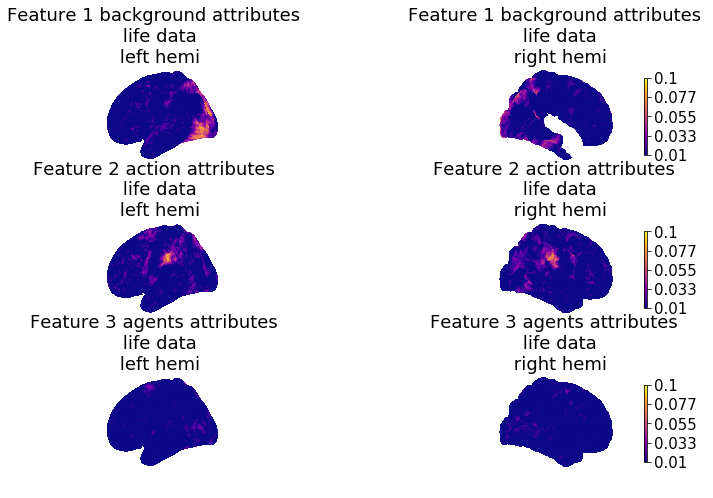

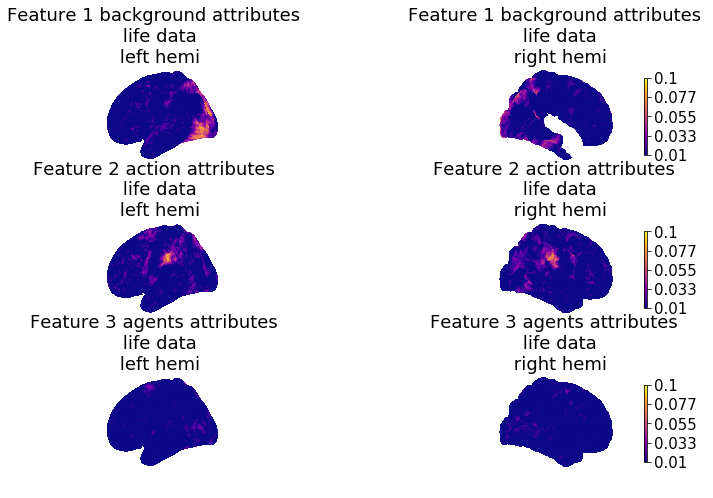

In [16]:
# f, axs = plt.subplots(2, 2)
figure, axes = plt.subplots(3,2,subplot_kw={'projection': '3d'},figsize = (12,8))

# background
plot_surf(fsaverage_inflated_L,np.asarray(bg_lh.samples[0]), 
          title='Feature 1 background attributes \n life data\n left hemi', 
          hemi='left', view = 'lateral', vmin=.01, vmax=.10, cmap = 'plasma',axes=axes[0][0])
plot_surf(fsaverage_gii_R,np.asarray(bg_rh.samples[0]), colorbar = True,
          title='Feature 1 background attributes \n life data\n right hemi', 
          hemi='right', view = 'lateral', vmin=.01, vmax=.10, cmap = 'plasma',axes=axes[0][1])

# action
plot_surf(fsaverage_inflated_L,np.asarray(action_lh.samples[0]), 
          title='Feature 2 action attributes \n life data\n left hemi', 
          hemi='left', view = 'lateral', vmin=.01, vmax=.10, cmap = 'plasma',axes=axes[1][0])
plot_surf(fsaverage_gii_R,np.asarray(action_rh.samples[0]), colorbar = True,
          title='Feature 2 action attributes \n life data\n right hemi', 
          hemi='right', view = 'lateral', vmin=.01, vmax=.10, cmap = 'plasma',axes=axes[1][1])

# agent
plot_surf(fsaverage_inflated_L, np.asarray(agent_lh.samples[0]), 
          title='Feature 3 agents attributes \n life data\n left hemi', 
          hemi='left', view = 'lateral', vmin=.01, vmax=.10, cmap = 'plasma',axes=axes[2][0])
plot_surf(fsaverage_gii_R,np.asarray(agent_rh.samples[0]), colorbar = True,
          title='Feature 3 agents attributes \n life data\n right hemi', 
          hemi='right', view = 'lateral', vmin=.01, vmax=.10, cmap = 'plasma',axes=axes[2][1])